### Clustering Geolocation Data in Python using DBSCAN and K-Means

Project Scope: We will be using Taxi dataset downloaded from Kaggle and perform clustering Geolocation Data using K-Means and demonstrate how to use DBSCAN (Density-Based Spatial Clustering of Applications with Noise) which discovers clusters of different shapes and sizes from data containing noise and outliers and HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) which performs DBSCAN over varying epsilon values and integrates the result to find a clustering that gives the best stability over epsilon. With Key clusters of these taxis, we can build service stations for all taxis operating in that region.

In [16]:
import pandas as pd
import numpy as np 
import hdbscan
import folium
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from kneed import KneeLocator
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [17]:
df = pd.read_csv('taxi_data.csv')
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [18]:
# check the content of the data
print('------First five lines of the data-------')
print(df.head())
print('------Data Shape-------')
print(df.shape)
print('-------Data Information------')
print(df.info())
print('------Data Discription-------')
print(df.describe())
print('------correlation-------')
print(df.corr())

------First five lines of the data-------
        LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank
------Data Shape-------
(838, 3)
-------Data Information------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LON     837 non-null    float64
 1   LAT     837 non-null    float64
 2   NAME    837 non-null    object 
dtypes: float64(2), object(1)
memory usage: 19.8+ KB
None
------Data Discription-------
              LON         LAT
count  837.000000  837.000000
mean    28.066357  -26.145757
std      0.216721    0.259974
min     27.284510  -26.712430
25%     27.890500  -26.301480
50%     28.048840  -26.199

In [19]:
# let's check if there are duplicates and null values 
print('Number of Duplicates: ', df.duplicated(subset=['LON', 'LAT']).values.sum())
print('Null Values: ', df.isna().sum().sum())

Number of Duplicates:  14
Null Values:  3


In [20]:
# let's remove the duplicates and drop null values 
print('Before removal of duplicates and null values: ', df.shape)

df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)

df.dropna(inplace=True)

print('After removal of duplicates and null values: ', df.shape)

Before removal of duplicates and null values:  (838, 3)
After removal of duplicates and null values:  (823, 3)


In [21]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


### Data Visualization 

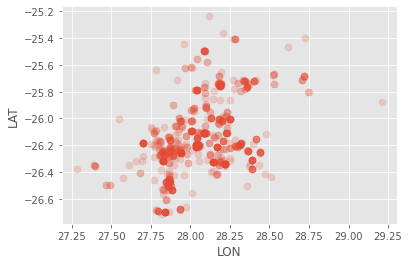

In [7]:
# let's plot the data points 
x = np.array(df[['LON', 'LAT']], dtype = 'float64')
plt.xlabel('LON')
plt.ylabel('LAT')
plt.scatter(x[:,0], x[:,1], alpha=0.2, s=50)

#### Next we will use Folium to Visualize the Geographical Data

In [8]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'\W+',',', row.NAME),
        fill=True
    ).add_to(m)
    
title = '''<h3 align="center" style="font-size:30px"><b>Given Data</b></h3>'''
m.get_root().html.add_child(folium.Element(title))

m

#### K-Means Clustering 

first and foremost, we find the best number of clusters using Elbow method. For each k value, we will initialise k-means and use the inertia attribute to identify the sum of squared distances of samples to the nearest cluster centre. As k increases, the sum of squared distance tends to zero. Imagine we set k to its maximum value n (where n is number of samples) each sample will form its own cluster meaning sum of squared distances equals zero.


In [22]:
# X = df[['LAT', 'LON']].values
x = np.array(df[['LON', 'LAT']], dtype = 'float64')
x

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

100%|███████████████████████████████████████████| 99/99 [00:32<00:00,  3.08it/s]


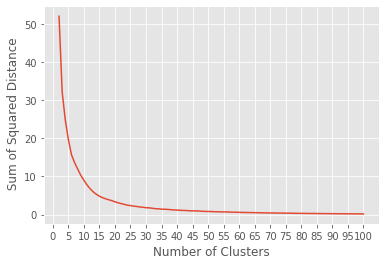

In [23]:
# sum_of_squared_distances =[]
# k = range(2,101)
# for i in k:
#     km = KMeans(n_clusters=i)
#     km = km.fit(x)
#     sum_of_squared_distances.append(km.inertia_)
    
    
sum_of_squared_distances = []
for i in tqdm(range(2, 101)):
    km = KMeans(n_clusters=i, random_state=0).fit(x)
#     km = km.fit(x)
    sum_of_squared_distances.append(km.inertia_)
    

plt.plot(range(2, 101), sum_of_squared_distances)
# plt.plot(k, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel(' Sum of Squared Distance')
plt.xticks(np.arange(0, 101, 5))
plt.show()

looking at the elbow curve above, getting the elbow point is not obvious. We can only guess. In this case, the elbow point falls between 10 and 11. We will further use the silhouette coefficient method to determine the value.  

The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:

How close the data point is to other points in the cluster
How far away the data point is from points in other clusters

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.

100%|███████████████████████████████████████████| 99/99 [00:35<00:00,  2.75it/s]


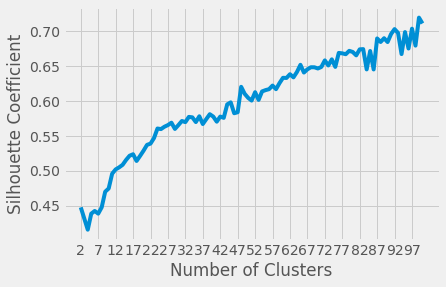

In [38]:
#sample code:
# A list holds the silhouette coefficients for each k
silhouette_coeff = []

# Notice you start at 2 clusters for silhouette coefficient
for k in tqdm(range(2, 101)):
    km = KMeans(n_clusters=k, random_state=0).fit(x)
    score = silhouette_score(x, km.labels_)
    silhouette_coeff.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 101), silhouette_coeff)
plt.xticks(range(2, 101, 5))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()   

In [24]:
# A list holds the silhouette coefficients for each k
# silhouette_coeff = []
score = -1 
m = 0
# Notice you start at 2 clusters for silhouette coefficient
for k in tqdm(range(2, 101)):
    km = KMeans(n_clusters=k, random_state=0).fit(x)
    score2 = silhouette_score(x, km.labels_)
    if score2 > score:
        score = score2
        m=i
#     silhouette_coeff.append(score)
print('The best number of clusters based on silhouette score is {} with a score of {}.'.format
      (m, score))

100%|███████████████████████████████████████████| 99/99 [00:35<00:00,  2.79it/s]

The best number of clusters based on silhouette score is 100 with a score of 0.7194737401976391.


Since the elbow method and silhouette score fails in giving us the best number of clusters, we will use Python package, kneed, to identify the elbow point programmatically:

In [25]:
kl = KneeLocator(range(2,101), sum_of_squared_distances, curve='convex', direction='decreasing')
kl.elbow

14

We see that the elbow point is 14! My guess was wrong. That is why is not good to guess!! Just be sure.

#### We will use n_clusters = 14, in the KMeans algorithm

In [23]:
# kmeans = KMeans(
#     init= 'random',
#     n_clusters = 14,
#     n_init= 10,
#     max_iter = 300,
#     random_state = 0 
# ).fit(x)

In [26]:
print(np.__version__) # downgraded to solve the nontype object error 

1.21.3


In [27]:
kmeans = KMeans(n_clusters=14, random_state=0).fit(x)
kmeans_pred = kmeans.predict(x)
df['cluster_kmeans']=kmeans_pred
print(df.head())

        LON       LAT                          NAME  cluster_kmeans
0  28.17858 -25.73882         11th Street Taxi Rank              13
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              13
2  27.83239 -26.53722          Adams Road Taxi Rank              11
3  28.12514 -26.26666  Alberton City Mall Taxi Rank              10
4  28.10144 -26.10567      Alexandra Main Taxi Rank               3


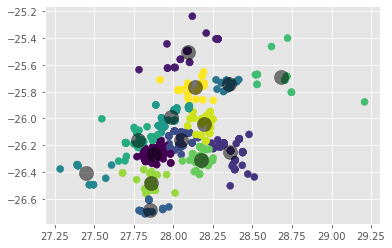

In [18]:
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=kmeans_pred, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

In [12]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 
          'olive', 'goldenrod', 'lightcyan', 'navy','springgreen','midnightblue',
         'red','brown','limegreen','lime','pink','orchid','crimson','m']*10
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
df['colors_kmeans'] = vectorizer(kmeans_pred)


def create_map(cluster_column, colors_column, title):
    map = folium.Map(location=[x[:,0].mean(), x[:,1].mean()], tiles='Stamen Toner', zoom_start=8.5)
    for _,row in df.iterrows():
        folium.CircleMarker(
            location=[row.LAT,row.LON],
            radius=5,
            popup=row[cluster_column],
            fill=True,
            color=row[colors_column],
            fill_color=row[colors_column],
        ).add_to(map)
        
    print(title)
    return map

create_map('cluster_kmeans', 'colors_kmeans', 'kmeans clustering')

kmeans clustering


#### DBSCAN

https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/

https://www.datanovia.com/en/lessons/dbscan-density-based-clustering-essentials/

DBSACAN (Density-Based Spatial Clustering of Application with Noise) is a density-based clustering algorithm that assumes that clusters are dense regions in space that are separated by regions having a lower density of data points. A unique feature of DBSCAN Clustering is that it is robust to ouliers, it does not require the number of clusters to be fed as input, unlike K-Means, it can find any shape of clusters

Before we proceed with DBSCAN Algorithm, we need to first find the most important parameter, epsilon, which is the maximum distance between points to create a cluster. We can find this using the NearestNeighbors algorithm.

<Figure size 360x360 with 0 Axes>

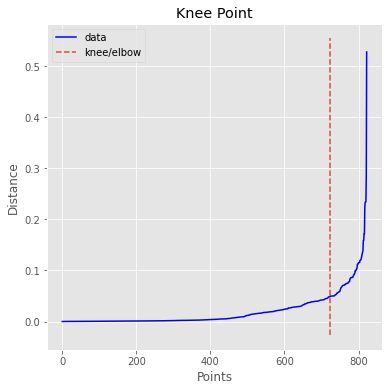

The elbow point is around 0.05


In [33]:
# we first find eps;
nearest_neighbors = NearestNeighbors(n_neighbors=6)
neighbors = nearest_neighbors.fit(x)
distances, indices = neighbors.kneighbors(x)
distances = np.sort(distances[:,5], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
# we use the polynomial interp_method to get a smooth line 
fig =plt.figure(figsize=(5,5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
print('The elbow point is around {}'.format(round(distances[knee.knee],3)))

Now that we have derived the optimal value of epsilon as 0.05 above, let us use this in the DBSCAN algorithm below.

Number of clusters found: 22
Estimated number of noise points: 75
Silhouette ignoring outliers:0.38380242764373135
Silhouette outliers as singletons: 0.1211725683046244


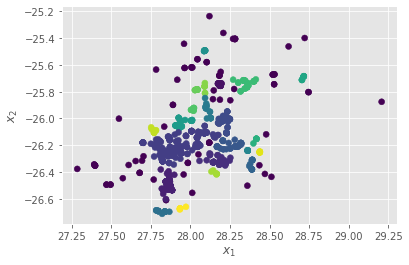

In [48]:
dbscan_cluster = DBSCAN(eps=0.05, min_samples=6)
dbscan_cluster.fit(x)

# Visualizing DBSCAN
plt.scatter(x[:,0], x[:,1], c=dbscan_cluster.labels_, label=x)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")    

#number of clusters 
labels = dbscan_cluster.labels_
N_clus = len(set(labels))-(1 if -1 in labels else 0)
print('Number of clusters found: {}'.format(N_clus))

#Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated number of noise points: {}'.format(n_noise))

# calculate v_measure
# from sklearn.metrics import v_measure_score
# print('v_measure=', v_measure_score(x, labels))

print(f'Silhouette ignoring outliers:{silhouette_score(x[labels!=-1], labels[labels!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(labels)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

Number of clusters found: 45
Estimated number of noise points: 316
Silhouette ignoring outliers:0.9262997062789708
Silhouette outliers as singletons: 0.5372599587276236


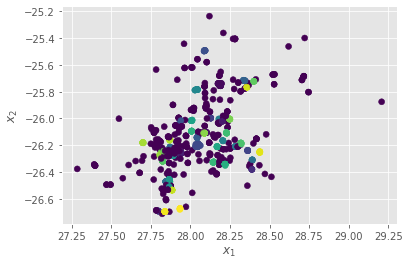

In [50]:
#let's try reducing the eps # i.e eps=0.01 

dbscan_cluster = DBSCAN(eps=0.01, min_samples=6)
dbscan_cluster.fit(x)

# Visualizing DBSCAN
plt.scatter(x[:,0], x[:,1], c=dbscan_cluster.labels_, label=x)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")    

#number of clusters 
labels = dbscan_cluster.labels_
N_clus = len(set(labels))-(1 if -1 in labels else 0)
print('Number of clusters found: {}'.format(N_clus))

#Identify Noise
n_noise = list(dbscan_cluster.labels_).count(-1)
print('Estimated number of noise points: {}'.format(n_noise))

# calculate v_measure
# from sklearn.metrics import v_measure_score
# print('v_measure=', v_measure_score(x, labels))

print(f'Silhouette ignoring outliers:{silhouette_score(x[labels!=-1], labels[labels!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(labels)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31..   check this link

#### HDBSCAN (Hierarchical Density-Based Spatial Clustering and Application with Noise

HDBSCAN is basically a DBSCAN implementation for varying epsilon values and therefore only needs the minimum cluster size as single input parameter. Unlike DBSCAN, this allows to it find clusters of variable densities without having to choose a suitable distance threshold first. HDBSCAN extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

Number of clusters found: 61
Estimated number of noise points: 149
Silhouette ignoring outliers:0.8159861507025821
Silhouette outliers as singletons: 0.6149017110598413


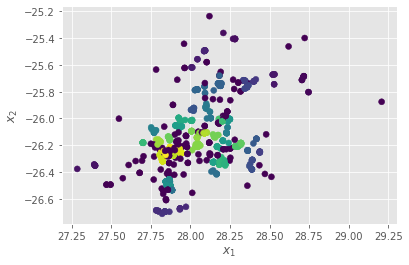

In [54]:
hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=0.01)
hdbscan_model.fit(x)

# Visualizing HDBSCAN
plt.scatter(x[:,0], x[:,1], c=hdbscan_model.labels_, label=x)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")    

#number of clusters 
h_labels = hdbscan_model.labels_
N_clus = len(set(h_labels))-(1 if -1 in h_labels else 0)
print('Number of clusters found: {}'.format(N_clus))

#Identify Noise
n_noise = list(hdbscan_model.labels_).count(-1)
print('Estimated number of noise points: {}'.format(n_noise))

print(f'Silhouette ignoring outliers:{silhouette_score(x[h_labels!=-1], h_labels[h_labels!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(h_labels)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

Unlike the DBSCAN Model, the HDBSCAN detected more clusters and less noise/ouliers

#### Conclusion 

Different clustering techinques were applied in this problem. We started with KMeans algorithm which is the simplest and fastest clustering algorithm. We showed that DBSCAN performs well on geographical data but selecting the epsilon value is critical. The HDBSCAN algorithm (it clustered more data and contains fewer outliers) is better to use on data with varying density which is applicable here since taxi density is higher around the city and is less away from the city.